In [3]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [7]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [8]:
# Change training classes if necessary
NUM_CLASSES = 8

# Dataset reading

In [9]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [10]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1596, 1663, 1510,  672,  164,  257,  139,  190]))


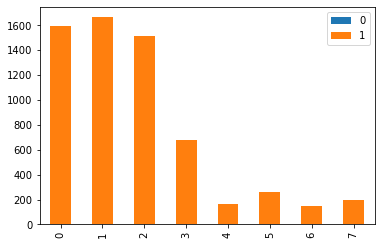

In [13]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [15]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1

In [16]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [17]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [18]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
73/73 [==============================] - 1s 4ms/step - loss: 1.7726 - accuracy: 0.2577 - val_loss: 1.3047 - val_accuracy: 0.5187

Epoch 00001: val_loss improved from inf to 1.30468, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
73/73 [==============================] - 0s 2ms/step - loss: 1.1964 - accuracy: 0.5731 - val_loss: 0.8488 - val_accuracy: 0.7332

Epoch 00002: val_loss improved from 1.30468 to 0.84880, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.7792 - accuracy: 0.7779 - val_loss: 0.5212 - val_accuracy: 0.8663

Epoch 00003: val_loss improved from 0.84880 to 0.52119, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.4804 - accuracy: 0.8585 - val_loss: 0.3188 - val_accuracy: 0.9289

Epoch 00004: val_loss improved from 0.52119 to 0.31882, saving 

In [19]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [20]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 639us/step - loss: 0.0273 - accuracy: 0.9955


In [21]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.0000000e+00 8.9877055e-12 3.9011928e-15 1.6443333e-12 1.6602475e-13
 6.7834215e-16 8.5482516e-27 2.3115381e-12]
0


# Confusion matrix

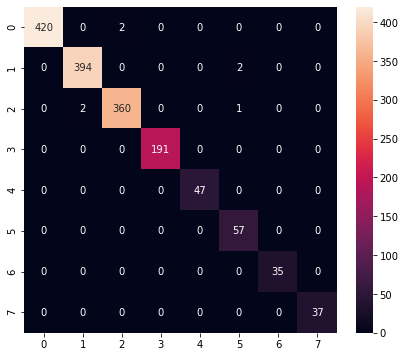

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       0.99      0.99      0.99       396
           2       0.99      0.99      0.99       363
           3       1.00      1.00      1.00       191
           4       1.00      1.00      1.00        47
           5       0.95      1.00      0.97        57
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00        37

    accuracy                           1.00      1548
   macro avg       0.99      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548



In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [24]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [25]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/4s/5y3h0y2j07q1qwglpyyvgcd80000gn/T/tmp4x4qxw7f/assets


7696

## Inference test

In [26]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [27]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [28]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [29]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 553 µs, sys: 1.04 ms, total: 1.59 ms
Wall time: 2.41 ms


In [30]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 1.0484769e-11 3.4106341e-15 2.7344897e-12 2.0613617e-13
 6.5833005e-16 1.3870842e-26 3.1283520e-12]
0


## Download model

In [ ]:
!zip -r model.zip keypoint_classifier  

updating: keypoint_classifier/ (stored 0%)
updating: keypoint_classifier/keypoint_classifier.tflite (deflated 22%)
updating: keypoint_classifier/keypoint_classifier.hdf5 (deflated 60%)




---


# ❗️Hyperparameters Tuning

In [31]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [32]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [33]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [34]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [35]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units_1': 16, 'num_units_2': 8, 'num_units_3': 8, 'dropout': 0.0, 'optimizer': 'adam'}
Epoch 1/50
73/73 [==============================] - 1s 3ms/step - loss: 2.0547 - accuracy: 0.0742 - val_loss: 1.8148 - val_accuracy: 0.2920

Epoch 00001: val_loss improved from inf to 1.81482, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7484 - accuracy: 0.2912 - val_loss: 1.5652 - val_accuracy: 0.3417

Epoch 00002: val_loss improved from 1.81482 to 1.56520, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4983 - accuracy: 0.3867 - val_loss: 1.3499 - val_accuracy: 0.5310

Epoch 00003: val_loss improved from 1.56520 to 1.34993, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/50
73/73 [==============================] - 0s 1ms/step - loss: 1.2832 - accuracy: 0.

In [ ]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!rm -rf logs